In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl 
import matplotlib.pyplot as plt

import json
import os
import re

from plotting import *

%matplotlib inline

## Performance over time (evaluation steps) - comparison across $D_{i \in \{Subj, Subj \cup Squad\}}$

In [2]:
# specify general hyperparameters
models = ['adversarial', 'linear', 'highway', 'recurrent', 'recurrent_highway']

metrics = ['batch_loss', 'batch_acc', 'batch_f1', 'val_f1', 'val_acc', 'val_loss']

task='QA'
version = 'train'
task_setting ='single'
iv = 'datasets'
aux = 'aux_1'

====== Task: QA ======

====== Model: ADVERSARIAL ======

===== Metric: BATCH_LOSS =====
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_grl_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_grl_subjqa_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_normal_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_normal_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_normal_grl_combined_multiple_per_epoch_qa.json
./results_train/QA/

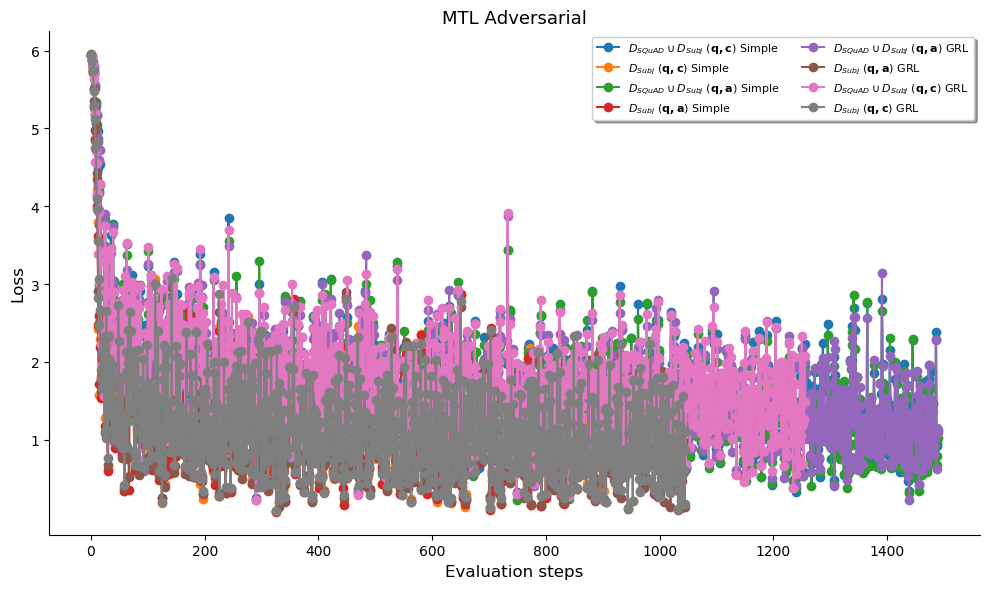

===== Metric: BATCH_ACC =====
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_grl_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_grl_subjqa_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_normal_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_normal_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_normal_grl_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_nor

<Figure size 432x288 with 0 Axes>

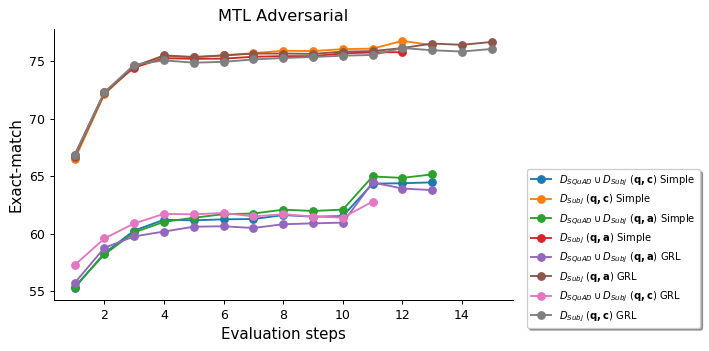

===== Metric: BATCH_F1 =====
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_grl_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_grl_subjqa_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_normal_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_normal_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_normal_grl_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_norm

<Figure size 432x288 with 0 Axes>

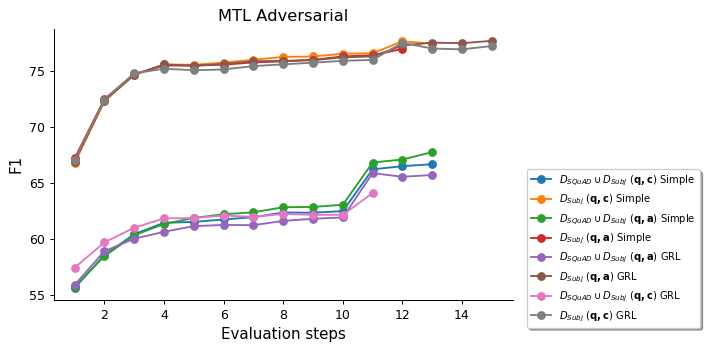

===== Metric: VAL_F1 =====
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_grl_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_grl_subjqa_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_normal_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_normal_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_normal_grl_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_normal

<Figure size 432x288 with 0 Axes>

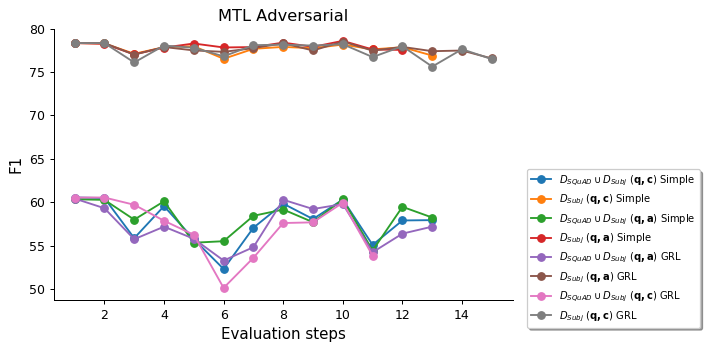

===== Metric: VAL_ACC =====
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_grl_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_grl_subjqa_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_normal_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_normal_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_normal_grl_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_norma

<Figure size 432x288 with 0 Axes>

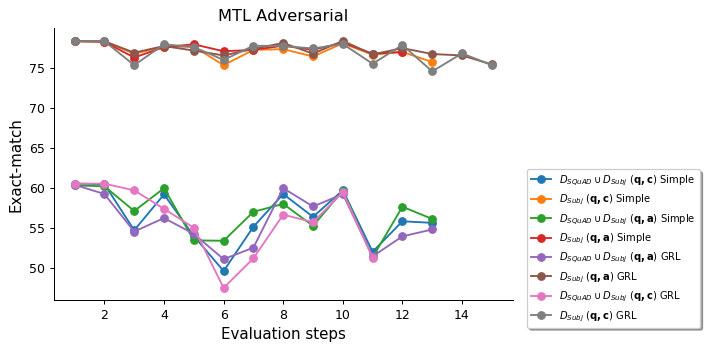

===== Metric: VAL_LOSS =====
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_grl_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_grl_subjqa_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_normal_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_normal_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_normal_grl_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_norm

<Figure size 432x288 with 0 Axes>

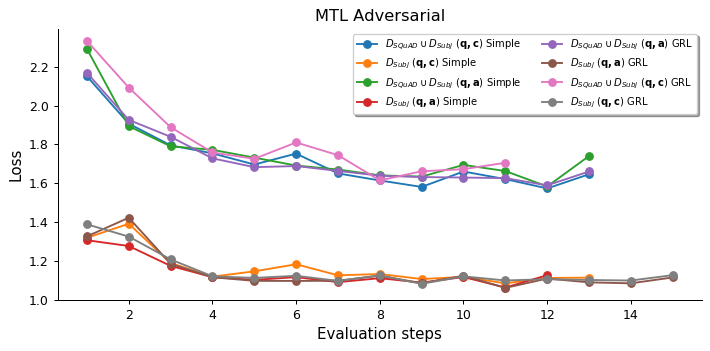

====== Model: LINEAR ======

===== Metric: BATCH_LOSS =====
./results_train/QA/linear/single/distilbert_linear___singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/linear/single/distilbert_linear___singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

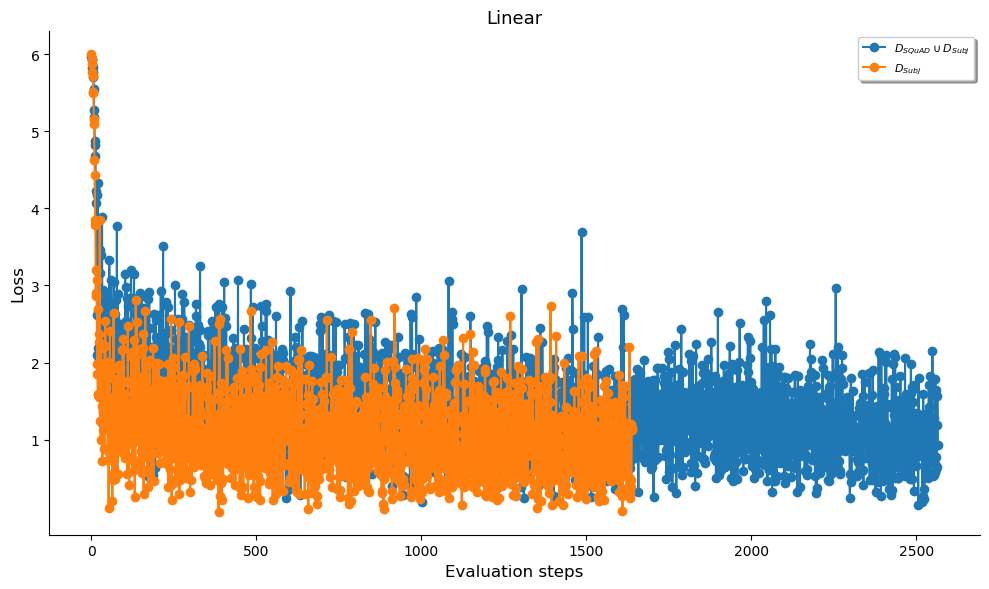

===== Metric: BATCH_ACC =====
./results_train/QA/linear/single/distilbert_linear___singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/linear/single/distilbert_linear___singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

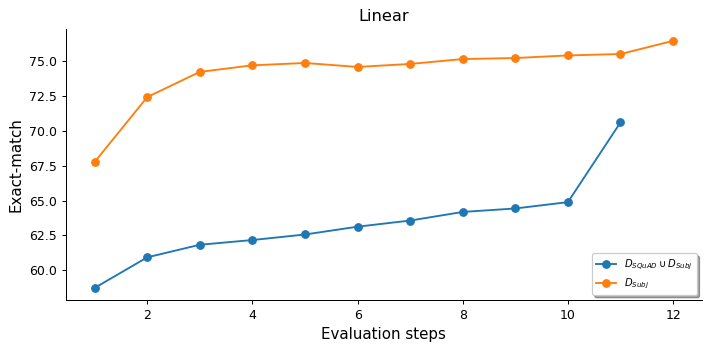

===== Metric: BATCH_F1 =====
./results_train/QA/linear/single/distilbert_linear___singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/linear/single/distilbert_linear___singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

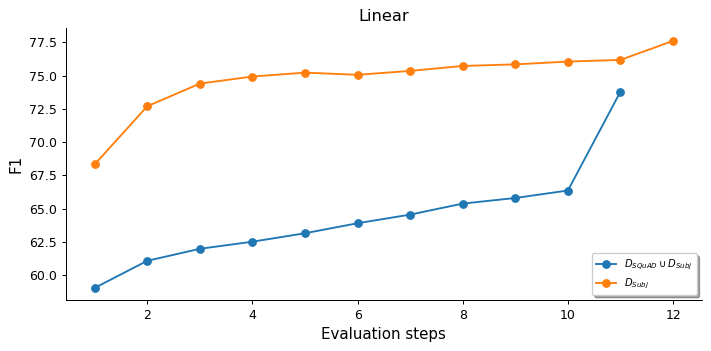

===== Metric: VAL_F1 =====
./results_train/QA/linear/single/distilbert_linear___singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/linear/single/distilbert_linear___singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

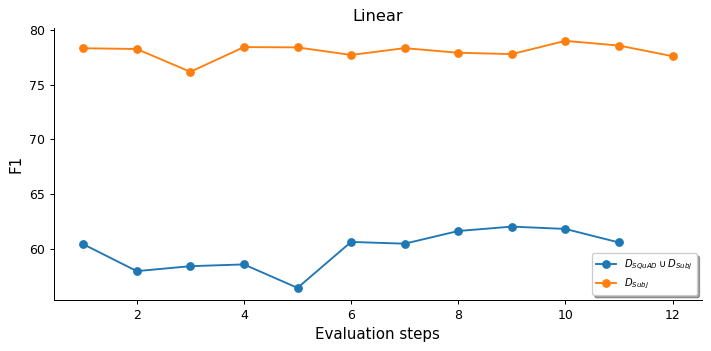

===== Metric: VAL_ACC =====
./results_train/QA/linear/single/distilbert_linear___singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/linear/single/distilbert_linear___singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

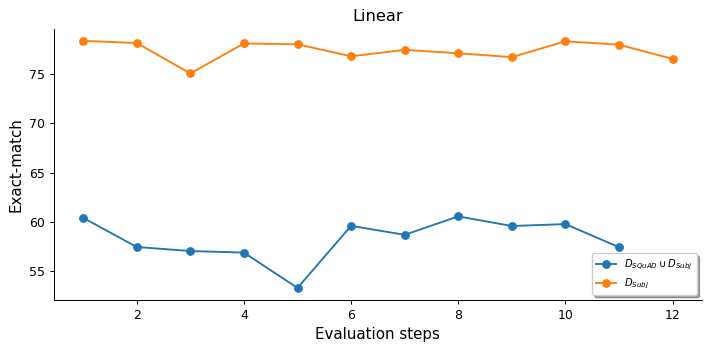

===== Metric: VAL_LOSS =====
./results_train/QA/linear/single/distilbert_linear___singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/linear/single/distilbert_linear___singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

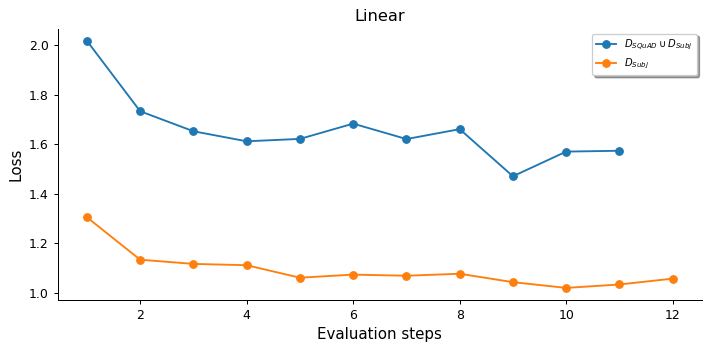

====== Model: HIGHWAY ======

===== Metric: BATCH_LOSS =====
./results_train/QA/highway/single/distilbert_linear_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/highway/single/distilbert_linear_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

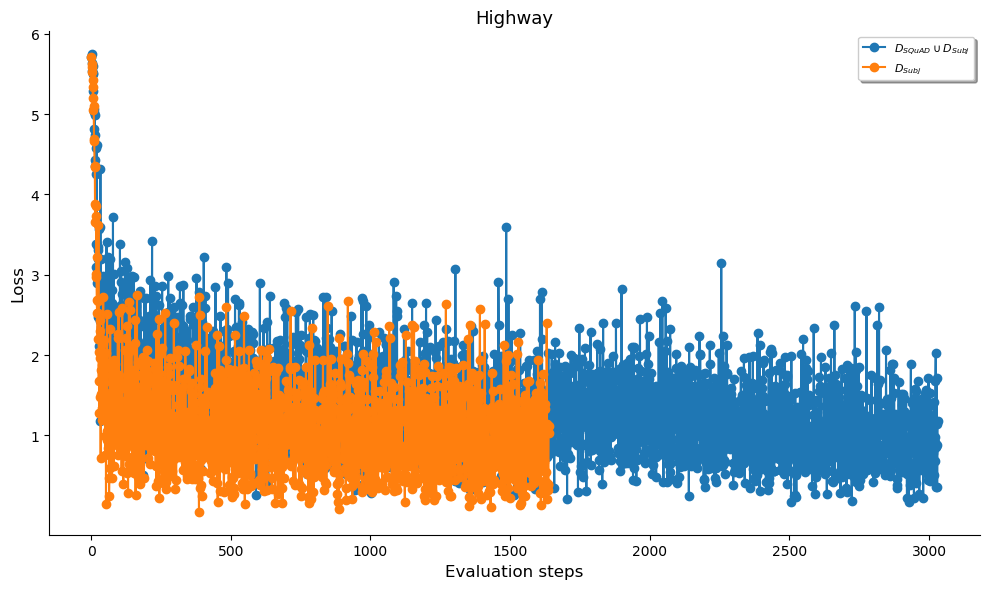

===== Metric: BATCH_ACC =====
./results_train/QA/highway/single/distilbert_linear_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/highway/single/distilbert_linear_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

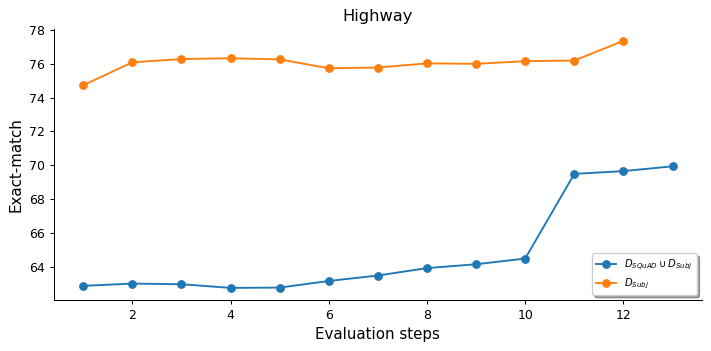

===== Metric: BATCH_F1 =====
./results_train/QA/highway/single/distilbert_linear_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/highway/single/distilbert_linear_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

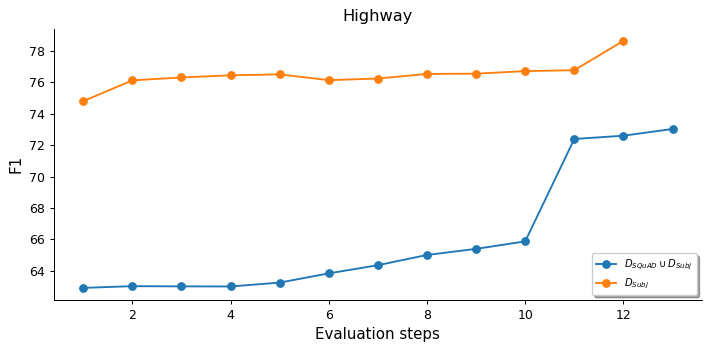

===== Metric: VAL_F1 =====
./results_train/QA/highway/single/distilbert_linear_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/highway/single/distilbert_linear_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

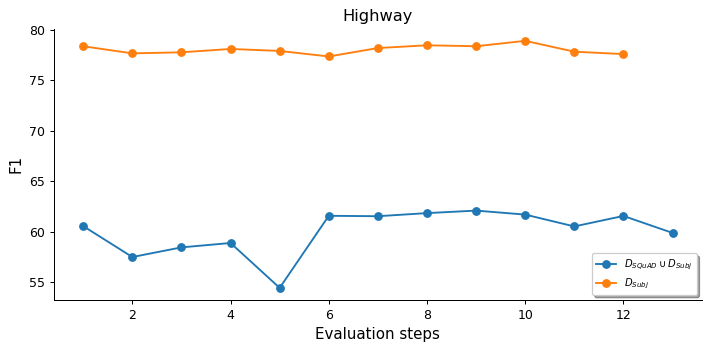

===== Metric: VAL_ACC =====
./results_train/QA/highway/single/distilbert_linear_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/highway/single/distilbert_linear_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

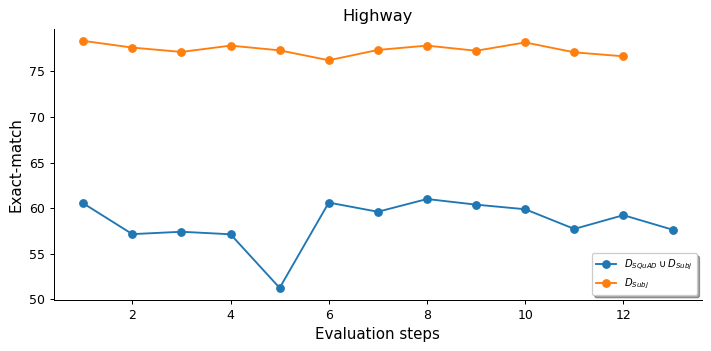

===== Metric: VAL_LOSS =====
./results_train/QA/highway/single/distilbert_linear_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/highway/single/distilbert_linear_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

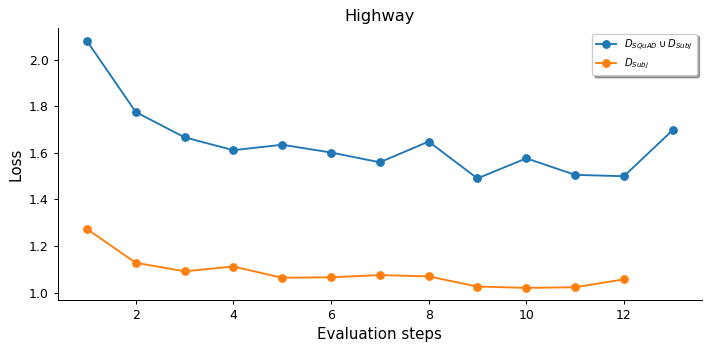

====== Model: RECURRENT ======

===== Metric: BATCH_LOSS =====
./results_train/QA/recurrent/single/distilbert_recurrent___singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/recurrent/single/distilbert_recurrent___singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

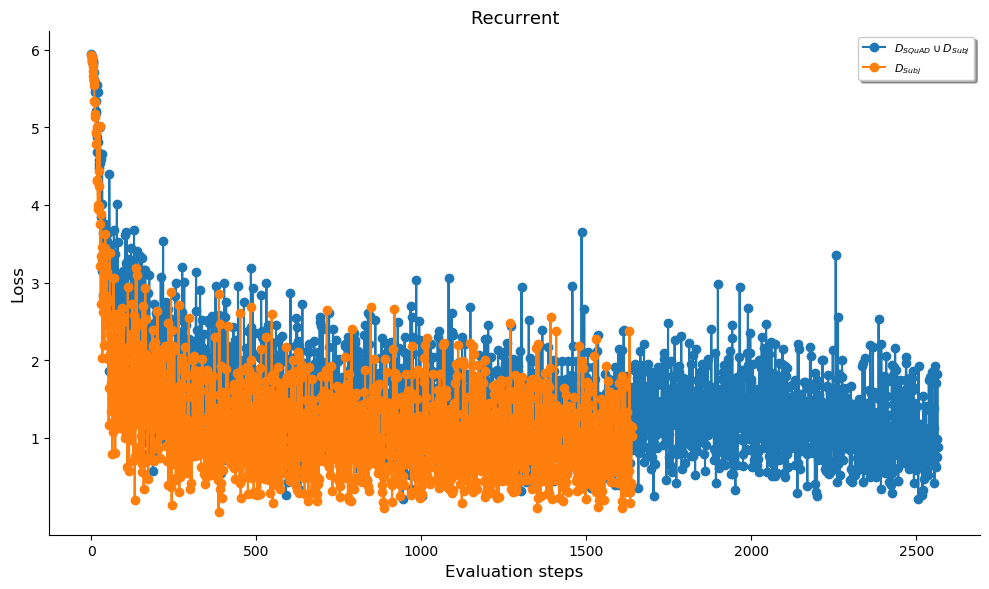

===== Metric: BATCH_ACC =====
./results_train/QA/recurrent/single/distilbert_recurrent___singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/recurrent/single/distilbert_recurrent___singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

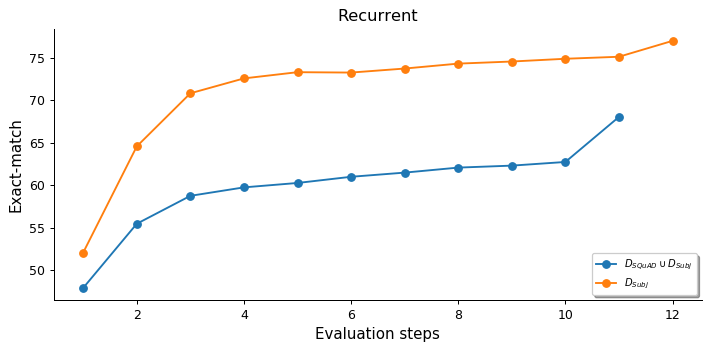

===== Metric: BATCH_F1 =====
./results_train/QA/recurrent/single/distilbert_recurrent___singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/recurrent/single/distilbert_recurrent___singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

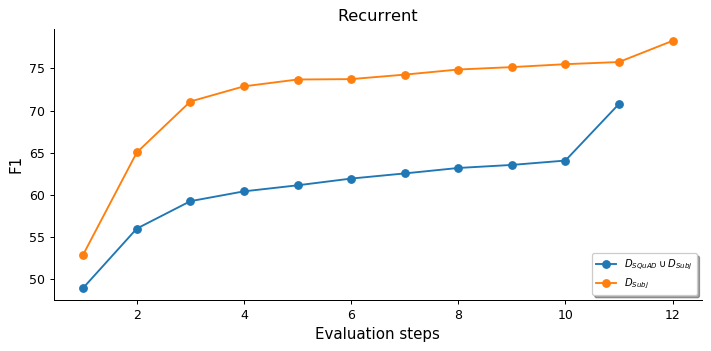

===== Metric: VAL_F1 =====
./results_train/QA/recurrent/single/distilbert_recurrent___singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/recurrent/single/distilbert_recurrent___singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

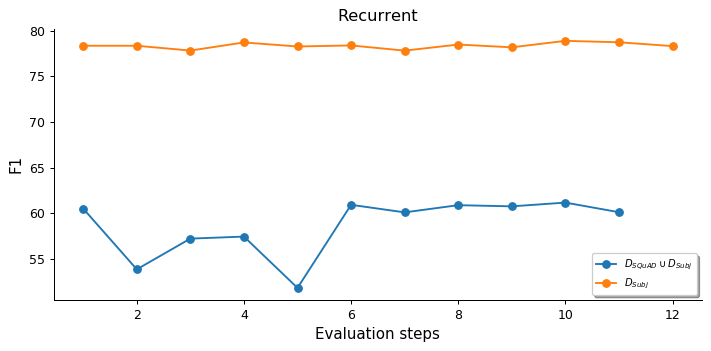

===== Metric: VAL_ACC =====
./results_train/QA/recurrent/single/distilbert_recurrent___singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/recurrent/single/distilbert_recurrent___singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

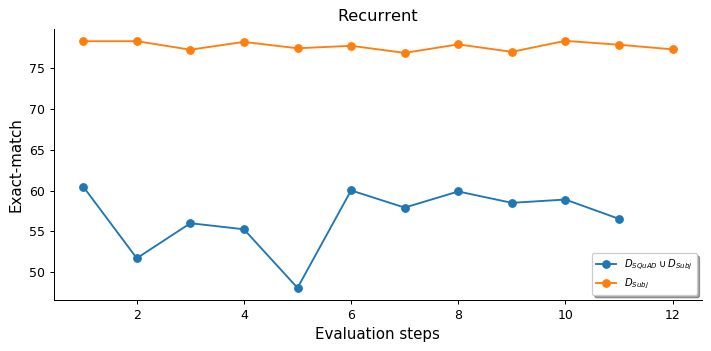

===== Metric: VAL_LOSS =====
./results_train/QA/recurrent/single/distilbert_recurrent___singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/recurrent/single/distilbert_recurrent___singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

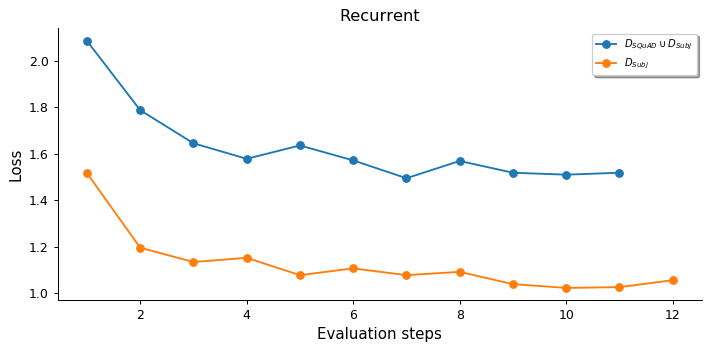

====== Model: RECURRENT_HIGHWAY ======

===== Metric: BATCH_LOSS =====
./results_train/QA/recurrent_highway/single/distilbert_recurrent_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/recurrent_highway/single/distilbert_recurrent_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

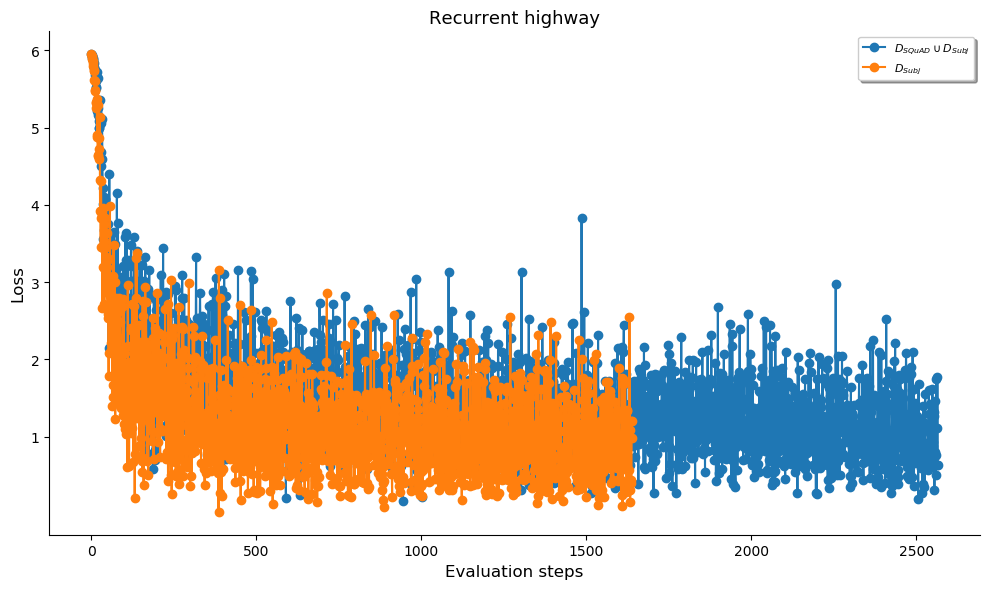

===== Metric: BATCH_ACC =====
./results_train/QA/recurrent_highway/single/distilbert_recurrent_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/recurrent_highway/single/distilbert_recurrent_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

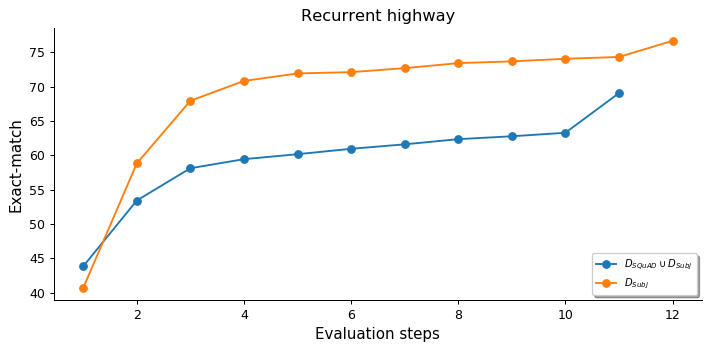

===== Metric: BATCH_F1 =====
./results_train/QA/recurrent_highway/single/distilbert_recurrent_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/recurrent_highway/single/distilbert_recurrent_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

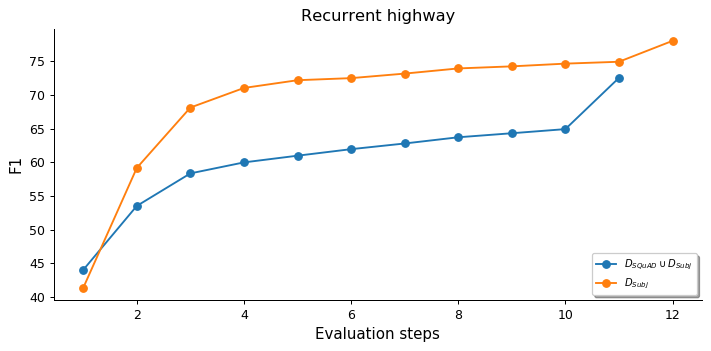

===== Metric: VAL_F1 =====
./results_train/QA/recurrent_highway/single/distilbert_recurrent_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/recurrent_highway/single/distilbert_recurrent_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

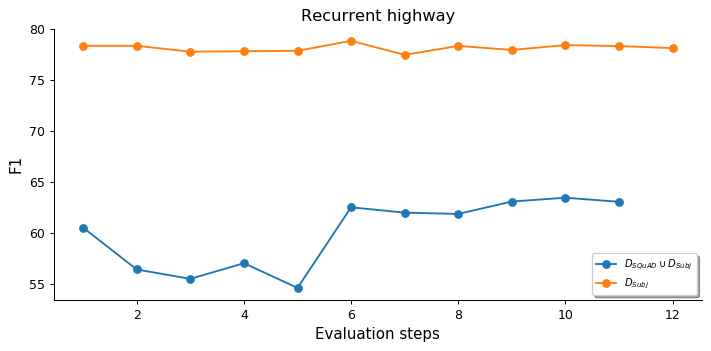

===== Metric: VAL_ACC =====
./results_train/QA/recurrent_highway/single/distilbert_recurrent_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/recurrent_highway/single/distilbert_recurrent_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

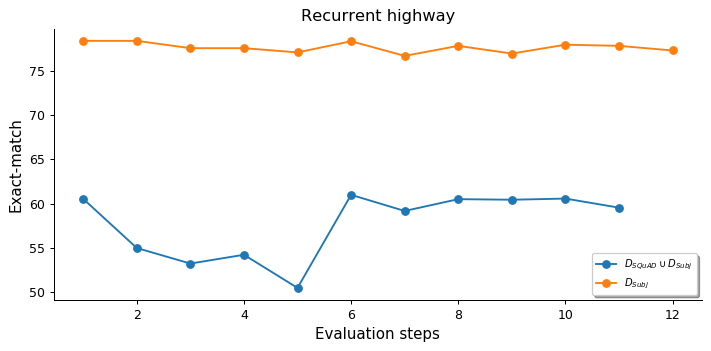

===== Metric: VAL_LOSS =====
./results_train/QA/recurrent_highway/single/distilbert_recurrent_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/recurrent_highway/single/distilbert_recurrent_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

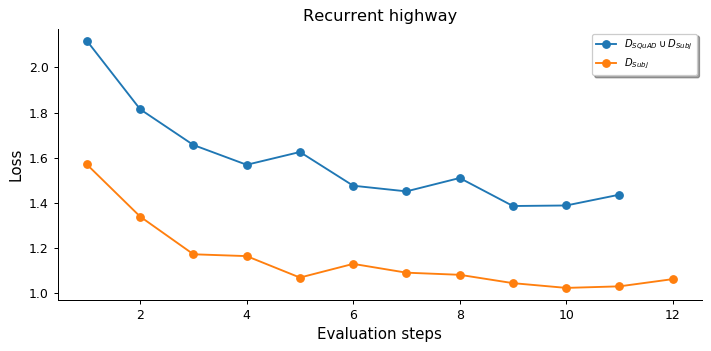

<Figure size 432x288 with 0 Axes>

In [3]:
plotting(models=models, metrics=metrics, task=task, version=version, task_setting=task_setting, iv=iv, aux=aux)

## Performance over time (evaluation steps) - comparison across $\tilde f$  \textit{ (i.e., models)}

In [4]:
# specify general hyperparameters
models = ['combined', 'SubjQA']

metrics = ['batch_loss', 'batch_acc', 'batch_f1', 'val_f1', 'val_acc', 'val_loss']

task='QA'
version = 'train'
task_setting ='single'
iv = 'models'
aux = 'aux_1'

====== Task: QA ======

====== Model: COMBINED ======

===== Metric: BATCH_LOSS =====
./results_train/QA/combined/single/distilbert_linear_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/single/distilbert_linear___singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/single/distilbert_recurrent_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/single/distilbert_recurrent___singletask__classic_combined_multiple_per_epoch_qa.json


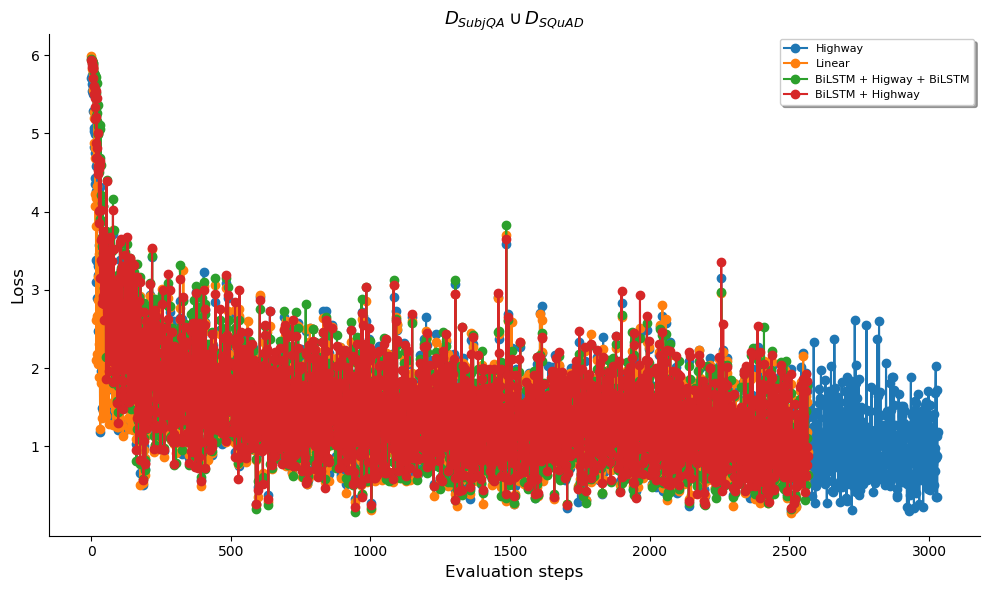

===== Metric: BATCH_ACC =====
./results_train/QA/combined/single/distilbert_linear_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/single/distilbert_linear___singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/single/distilbert_recurrent_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/single/distilbert_recurrent___singletask__classic_combined_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

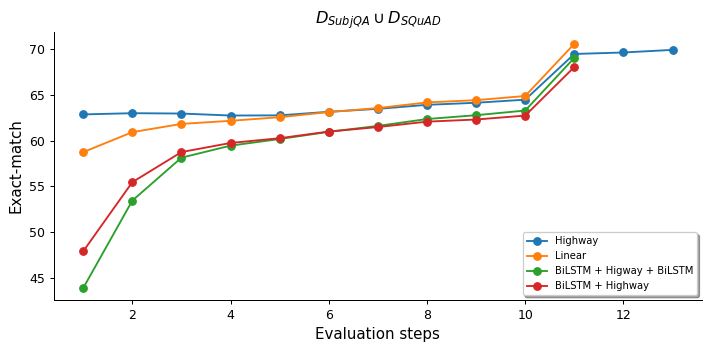

===== Metric: BATCH_F1 =====
./results_train/QA/combined/single/distilbert_linear_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/single/distilbert_linear___singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/single/distilbert_recurrent_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/single/distilbert_recurrent___singletask__classic_combined_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

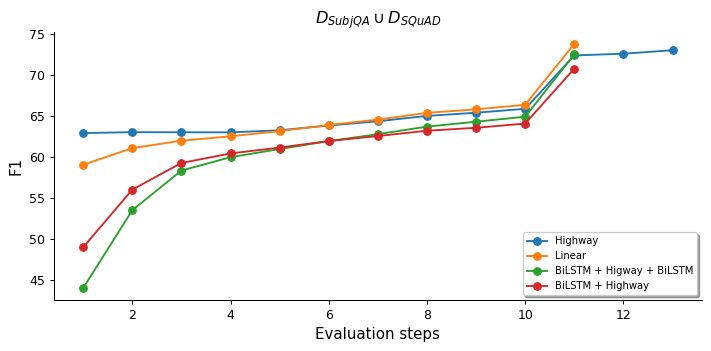

===== Metric: VAL_F1 =====
./results_train/QA/combined/single/distilbert_linear_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/single/distilbert_linear___singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/single/distilbert_recurrent_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/single/distilbert_recurrent___singletask__classic_combined_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

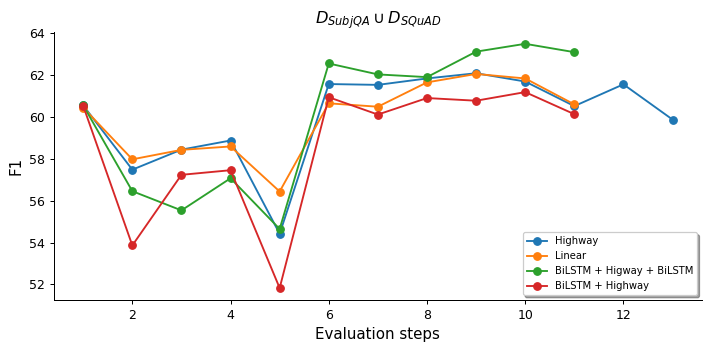

===== Metric: VAL_ACC =====
./results_train/QA/combined/single/distilbert_linear_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/single/distilbert_linear___singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/single/distilbert_recurrent_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/single/distilbert_recurrent___singletask__classic_combined_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

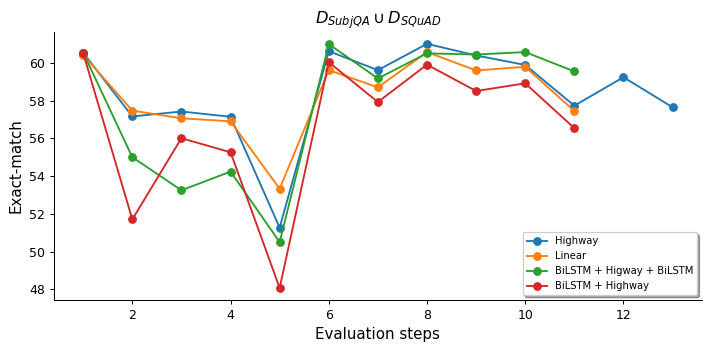

===== Metric: VAL_LOSS =====
./results_train/QA/combined/single/distilbert_linear_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/single/distilbert_linear___singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/single/distilbert_recurrent_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/single/distilbert_recurrent___singletask__classic_combined_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

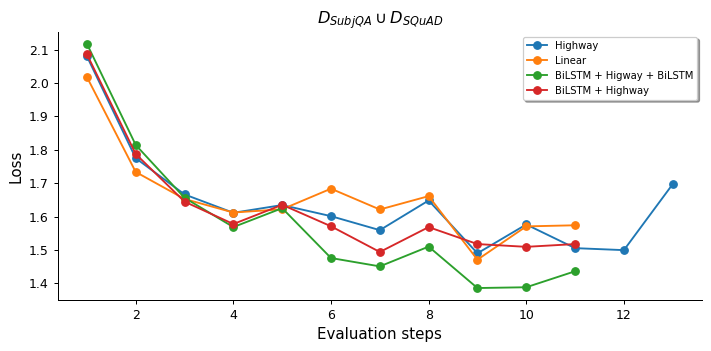

====== Model: SUBJQA ======

===== Metric: BATCH_LOSS =====
./results_train/QA/SubjQA/single/distilbert_linear_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_linear___singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_recurrent_highway_bilstm_singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_recurrent_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_recurrent___singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

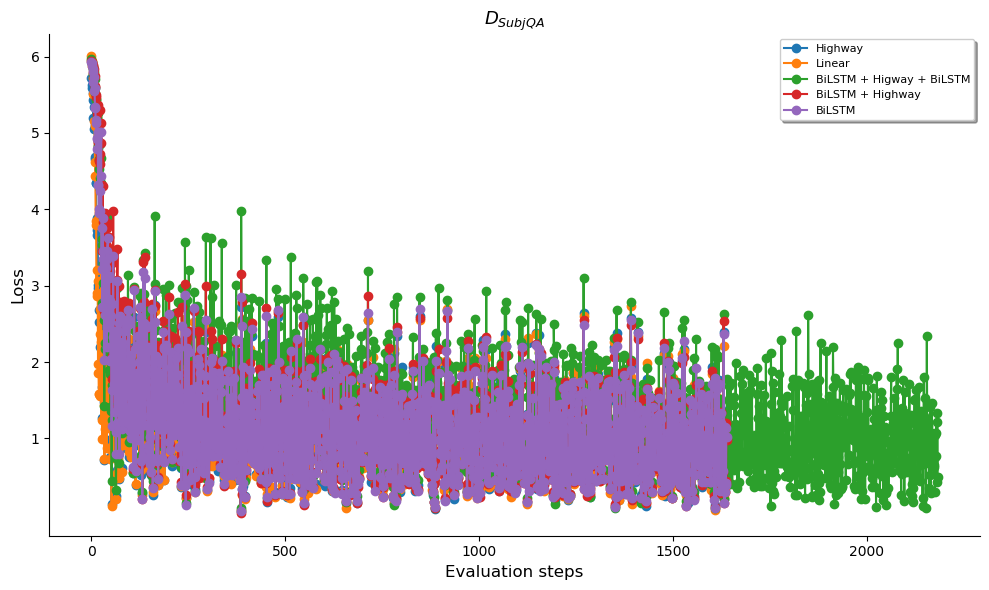

===== Metric: BATCH_ACC =====
./results_train/QA/SubjQA/single/distilbert_linear_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_linear___singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_recurrent_highway_bilstm_singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_recurrent_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_recurrent___singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

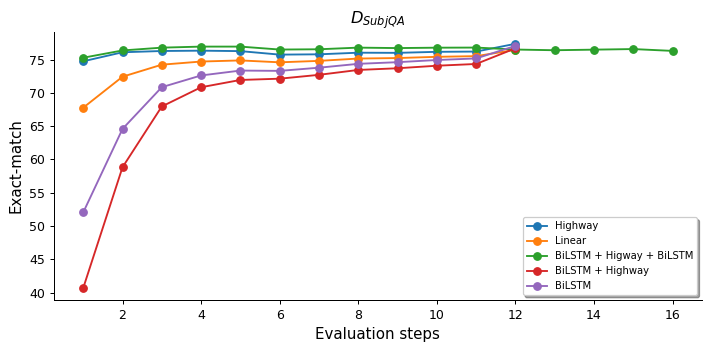

===== Metric: BATCH_F1 =====
./results_train/QA/SubjQA/single/distilbert_linear_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_linear___singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_recurrent_highway_bilstm_singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_recurrent_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_recurrent___singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

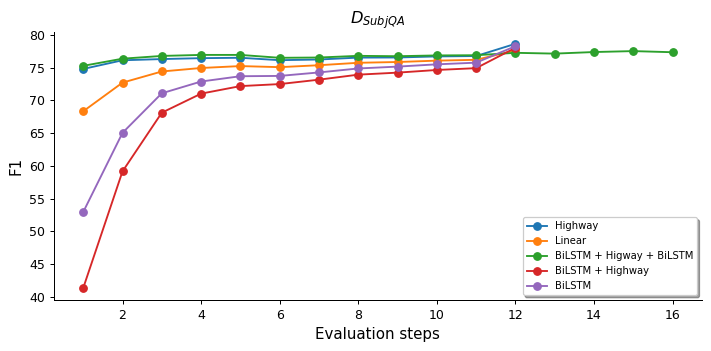

===== Metric: VAL_F1 =====
./results_train/QA/SubjQA/single/distilbert_linear_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_linear___singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_recurrent_highway_bilstm_singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_recurrent_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_recurrent___singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

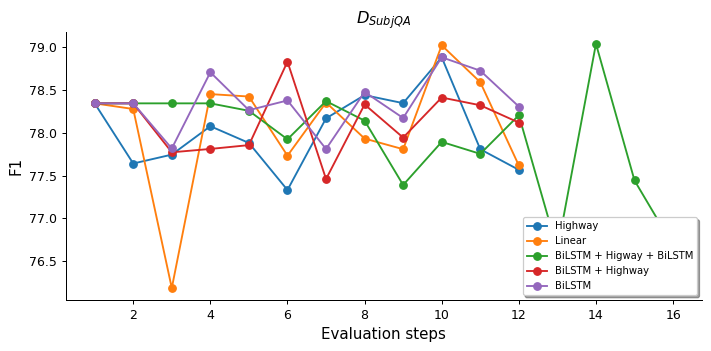

===== Metric: VAL_ACC =====
./results_train/QA/SubjQA/single/distilbert_linear_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_linear___singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_recurrent_highway_bilstm_singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_recurrent_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_recurrent___singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

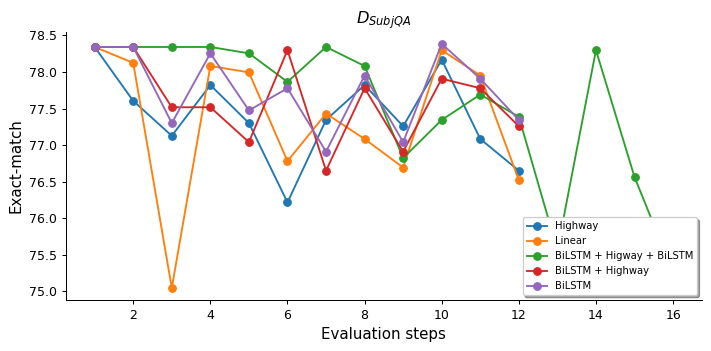

===== Metric: VAL_LOSS =====
./results_train/QA/SubjQA/single/distilbert_linear_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_linear___singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_recurrent_highway_bilstm_singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_recurrent_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/single/distilbert_recurrent___singletask__classic_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

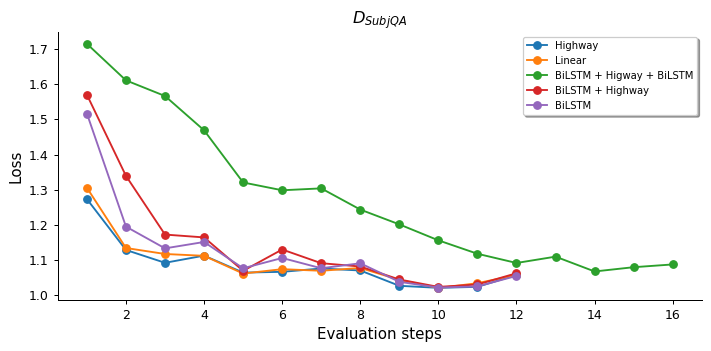

<Figure size 432x288 with 0 Axes>

In [5]:
plotting(models=models, metrics=metrics, task=task, version=version, task_setting=task_setting, iv=iv, aux=aux)

In [6]:
# specify general hyperparameters
models = ['combined', 'SubjQA']

metrics = ['batch_loss', 'batch_acc', 'batch_f1', 'val_f1', 'val_acc', 'val_loss']

task='QA'
version = 'train'
task_setting ='multi'
iv = 'models'
aux = 'aux_1'

====== Task: QA ======

====== Model: COMBINED ======

===== Metric: BATCH_LOSS =====
./results_train/QA/combined/multi/distilbert_linear___multitask_1_alternating_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_alternating_classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_alternating_grl_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_normal_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_normal_classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_normal_grl_combined_multiple_per_epoch_qa.json


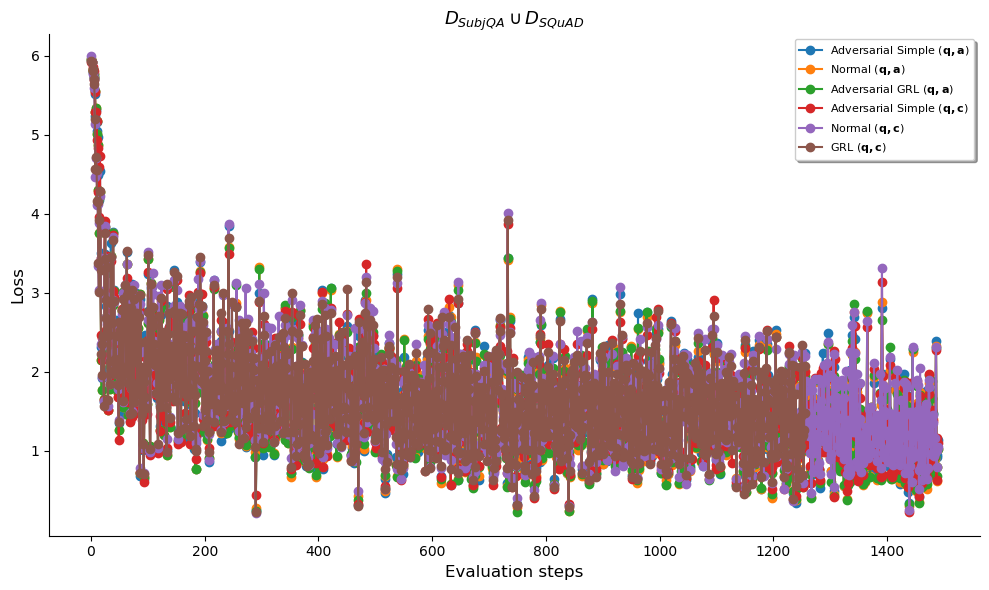

===== Metric: BATCH_ACC =====
./results_train/QA/combined/multi/distilbert_linear___multitask_1_alternating_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_alternating_classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_alternating_grl_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_normal_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_normal_classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_normal_grl_combined_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

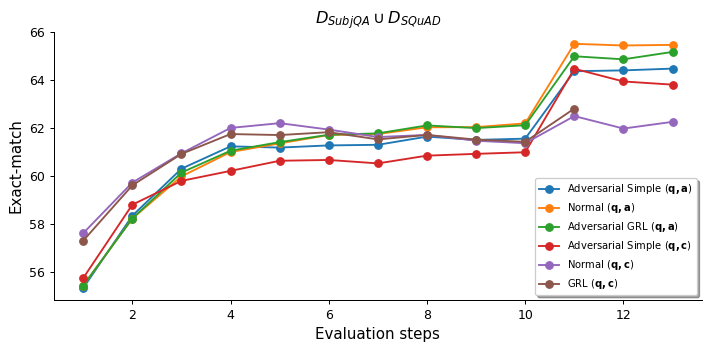

===== Metric: BATCH_F1 =====
./results_train/QA/combined/multi/distilbert_linear___multitask_1_alternating_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_alternating_classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_alternating_grl_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_normal_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_normal_classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_normal_grl_combined_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

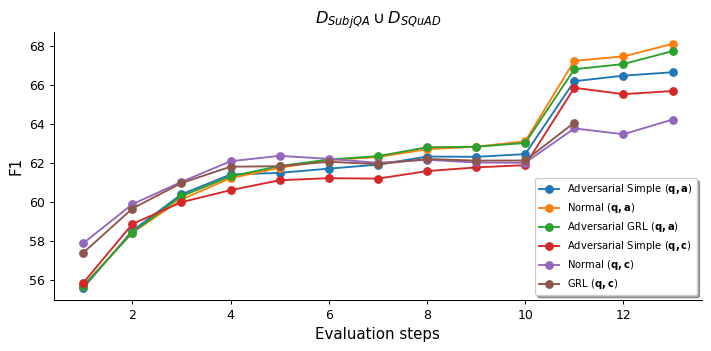

===== Metric: VAL_F1 =====
./results_train/QA/combined/multi/distilbert_linear___multitask_1_alternating_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_alternating_classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_alternating_grl_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_normal_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_normal_classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_normal_grl_combined_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

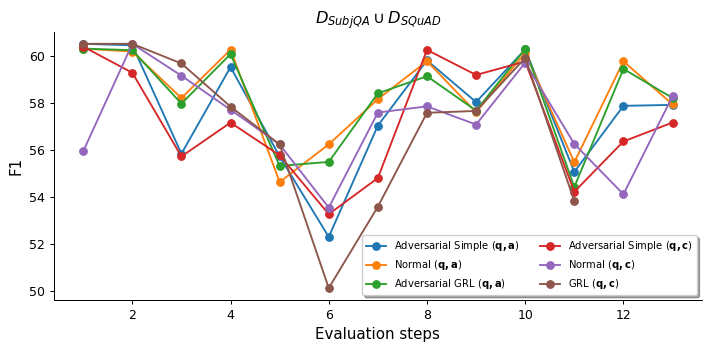

===== Metric: VAL_ACC =====
./results_train/QA/combined/multi/distilbert_linear___multitask_1_alternating_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_alternating_classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_alternating_grl_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_normal_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_normal_classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_normal_grl_combined_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

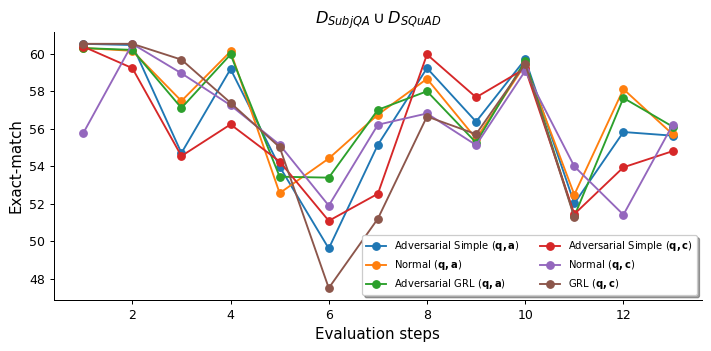

===== Metric: VAL_LOSS =====
./results_train/QA/combined/multi/distilbert_linear___multitask_1_alternating_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_alternating_classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_alternating_grl_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_normal_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_normal_classic_combined_multiple_per_epoch_qa.json
./results_train/QA/combined/multi/distilbert_linear___multitask_1_normal_grl_combined_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

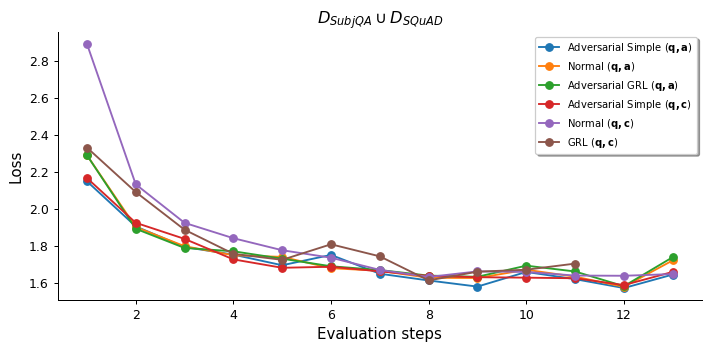

====== Model: SUBJQA ======

===== Metric: BATCH_LOSS =====
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_alternating_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_alternating_classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_alternating_grl_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_normal_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_normal_classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_normal_grl_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

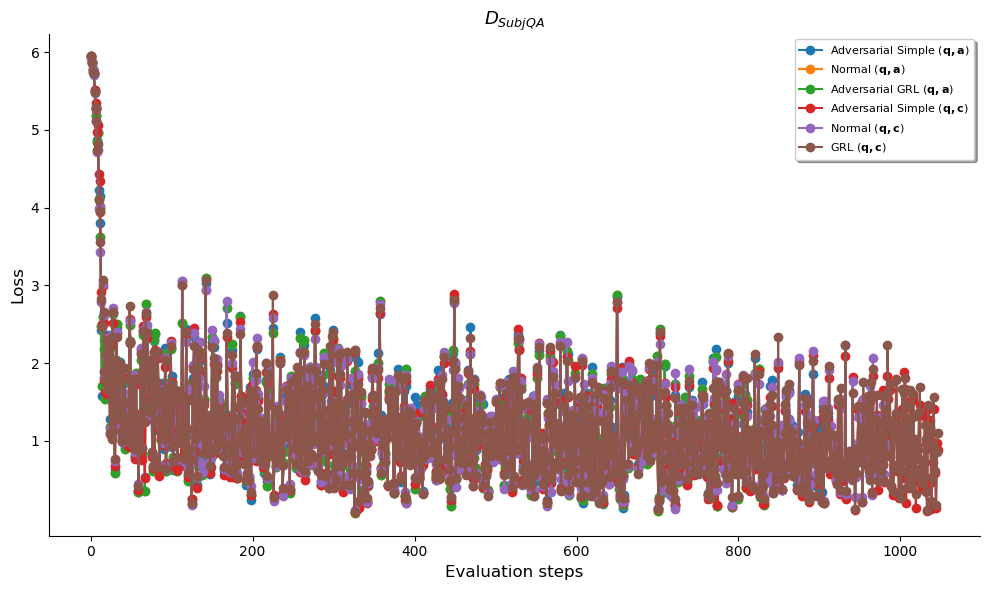

===== Metric: BATCH_ACC =====
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_alternating_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_alternating_classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_alternating_grl_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_normal_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_normal_classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_normal_grl_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

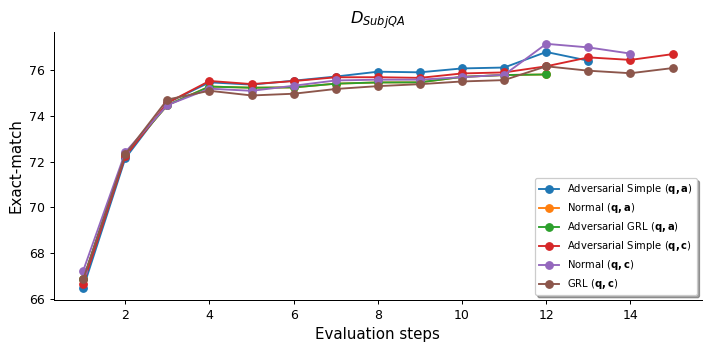

===== Metric: BATCH_F1 =====
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_alternating_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_alternating_classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_alternating_grl_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_normal_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_normal_classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_normal_grl_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

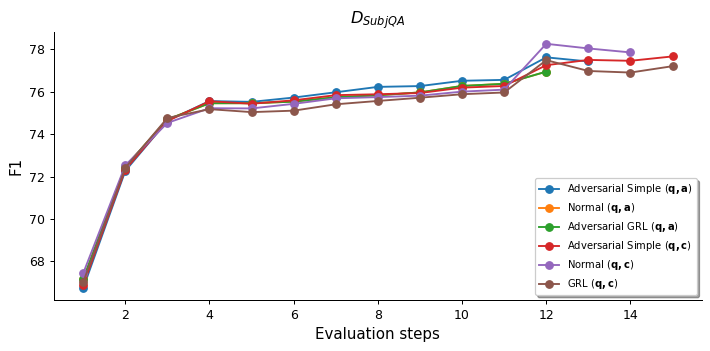

===== Metric: VAL_F1 =====
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_alternating_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_alternating_classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_alternating_grl_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_normal_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_normal_classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_normal_grl_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

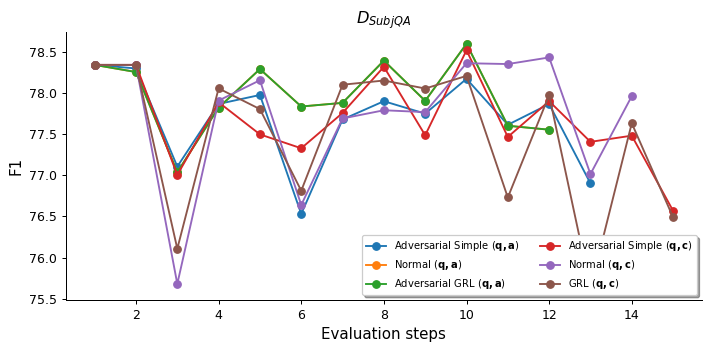

===== Metric: VAL_ACC =====
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_alternating_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_alternating_classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_alternating_grl_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_normal_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_normal_classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_normal_grl_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

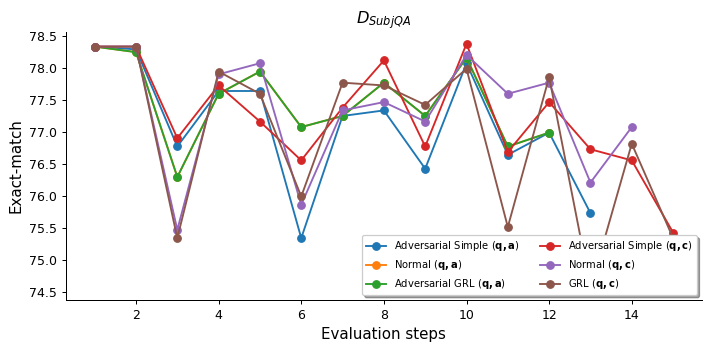

===== Metric: VAL_LOSS =====
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_alternating_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_alternating_classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_alternating_grl_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_normal_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_normal_classic_subjqa_multiple_per_epoch_qa.json
./results_train/QA/SubjQA/multi/distilbert_linear___multitask_1_normal_grl_subjqa_multiple_per_epoch_qa.json


<Figure size 432x288 with 0 Axes>

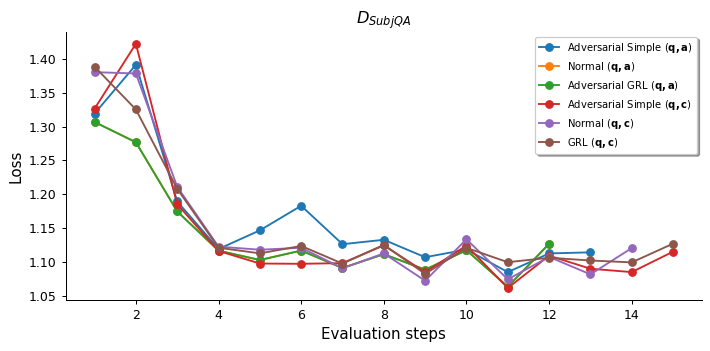

<Figure size 432x288 with 0 Axes>

In [7]:
plotting(models=models, metrics=metrics, task=task, version=version, task_setting=task_setting, iv=iv, aux=aux)

## \textit{Correlation plots}: performance on dev set as a function of performance on train set

./results_train/QA/highway/single/distilbert_linear_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/highway/single/distilbert_linear_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json


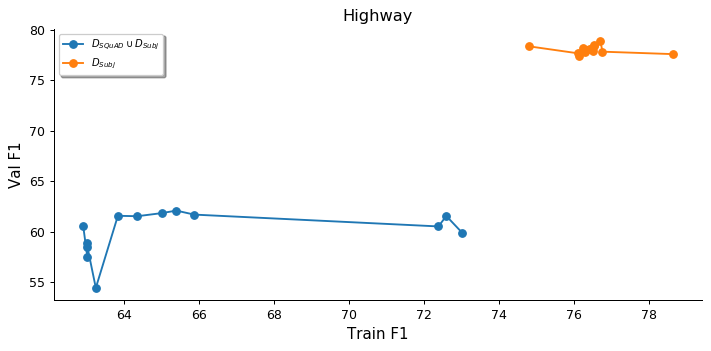

<Figure size 432x288 with 0 Axes>

In [8]:
task = 'QA'
version = 'train'
model = 'highway'
task_setting = 'single'
iv = 'datasets'
metric = ''

all_results = get_results(task=task, version=version, model=model, task_setting=task_setting, aux=None)
plot_results(all_results, task=task, metric=metric, iv=iv,  model=model, task_setting=task_setting, aux=None, correlation=True)

./results_train/QA/linear/single/distilbert_linear___singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/linear/single/distilbert_linear___singletask__classic_subjqa_multiple_per_epoch_qa.json


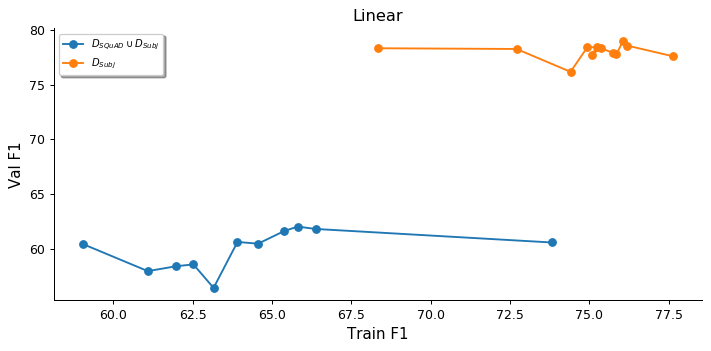

<Figure size 432x288 with 0 Axes>

In [9]:
task = 'QA'
version = 'train'
model = 'linear'
task_setting = 'single'
iv = 'datasets'
metric = ''

all_results = get_results(task=task, version=version, model=model, task_setting=task_setting, aux=None)
plot_results(all_results,task=task, metric=metric, iv=iv,  model=model, task_setting=task_setting, aux=None, correlation=True)

./results_train/QA/recurrent/single/distilbert_recurrent___singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/recurrent/single/distilbert_recurrent___singletask__classic_subjqa_multiple_per_epoch_qa.json


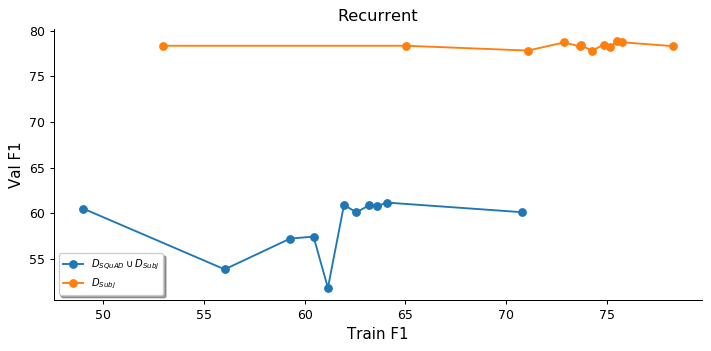

<Figure size 432x288 with 0 Axes>

In [10]:
task = 'QA'
version = 'train'
model = 'recurrent'
task_setting = 'single'
iv = 'datasets'
metric = ''

all_results = get_results(task=task, version=version, model=model, task_setting=task_setting, aux=None)
plot_results(all_results,task=task, metric=metric, iv=iv,  model=model, task_setting=task_setting, aux=None, correlation=True)

./results_train/QA/recurrent_highway/single/distilbert_recurrent_highway__singletask__classic_combined_multiple_per_epoch_qa.json
./results_train/QA/recurrent_highway/single/distilbert_recurrent_highway__singletask__classic_subjqa_multiple_per_epoch_qa.json


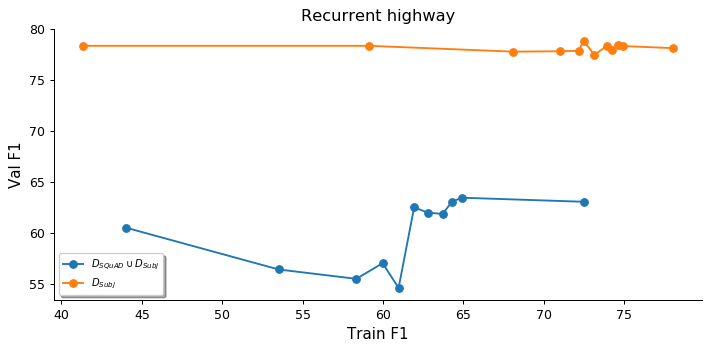

<Figure size 432x288 with 0 Axes>

In [11]:
task = 'QA'
version = 'train'
model = 'recurrent_highway'
task_setting = 'single'
iv = 'datasets'
metric = ''

all_results = get_results(task=task, version=version, model=model, task_setting=task_setting, aux=None)
plot_results(all_results,task=task, metric=metric, iv=iv,  model=model, task_setting=task_setting, aux=None, correlation=True)

./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_grl_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_alternating_grl_subjqa_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_normal_advsimple_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_normal_advsimple_subjqa_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_normal_grl_combined_multiple_per_epoch_qa.json
./results_train/QA/adversarial/multi/aux_1/distilbert_linear___multitask_1_normal_grl_subjqa_multiple_per_ep

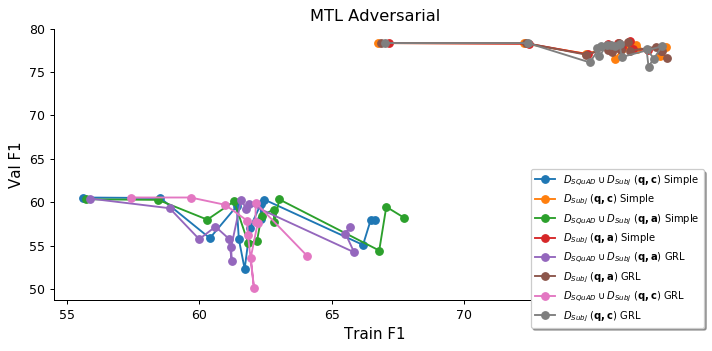

<Figure size 432x288 with 0 Axes>

In [12]:
task = 'QA'
version = 'train'
model = 'adversarial'
task_setting = 'multi'
iv = 'methods'
metric = ''
aux = 'aux_1'

all_results = get_results(task=task, version=version, model=model, task_setting=task_setting, aux=aux)
plot_results(all_results, task=task, metric=metric, iv=iv,  model=model, task_setting=task_setting, aux=aux, correlation=True)